In [17]:
import cv2, sys, numpy, os,time
import skimage.io as io
#import names


In [18]:
def train_lbph_input(images):
    #images_lbp=localBinaryPattern(images)
    print(images.shape)
    hist = []  
    face_resize = cv2.resize(images, (256, 256))  
    (s2,s3) = face_resize.shape        
    img_lbp = numpy.zeros((s2,s3,1), numpy.uint8)  
    io.imshow(face_resize)
    io.show()
    for i in range(0, s2):
        for j in range(0, s3):  
            img_lbp[i, j] = lbp_calculated_pixel(face_resize, i, j)  
    hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])  
    hist.append(hist_lbp)
                #print(hist_lbp)  
         # images_lbp=localBinaryPattern(images)  
         #   
    return hist 

In [19]:
def train_lbph(images):
    #images_lbp=localBinaryPattern(images)
    #print(images.shape)
    s1 = images.shape[0]
    hist = []  
    for k in range(s1):
        for face in images[k]:
            face_resize = cv2.resize(face, (256, 256))  
            (s2,s3) = face_resize.shape
            img_lbp = numpy.zeros((s2,s3,1), numpy.uint8)  
            for i in range(0, s2):
                for j in range(0, s3):  
                    img_lbp[i, j] = lbp_calculated_pixel(face_resize, i, j)  
            hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])  
            hist.append(hist_lbp)
                #print(hist_lbp)  
         # images_lbp=localBinaryPattern(images)  
         #   
    return hist 

In [20]:
def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

In [21]:
def lbp_calculated_pixel(img, x, y):  
    '''  
    64 | 128 |   1  
     ----------------  
    32 |   0 |   2  
    ----------------  
     16 |   8 |   4      
    '''      
    center = img[x][y]
    val_ar = []  
    val_ar.append(get_pixel(img, center, x-1, y+1))     # top_right  
    val_ar.append(get_pixel(img, center, x, y+1))       # right  
    val_ar.append(get_pixel(img, center, x+1, y+1))     # bottom_right  
    val_ar.append(get_pixel(img, center, x+1, y))       # bottom  
    val_ar.append(get_pixel(img, center, x+1, y-1))     # bottom_left  
    val_ar.append(get_pixel(img, center, x, y-1))       # left  
    val_ar.append(get_pixel(img, center, x-1, y-1))     # top_left  
    val_ar.append(get_pixel(img, center, x-1, y))       # top  
            
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]  
    val = 0  
    for i in range(len(val_ar)):  
        val += val_ar[i] * power_val[i]  
    return val     

In [34]:
#compares from training and coming image
def predict_lbph(input_image,recognizer,labels):
    #print('recognizer: ',recognizer.shape)
#     display('input_image.shape: ',input_image.shape)
    #print(input_image.shape)
    #print(recognizer.shape)
    s1,s2=input_image.shape[0],input_image.shape[1]
    d1=recognizer.shape[0]
    #(d1,d2,d3)=recognizer.shape
    temp=numpy.zeros((1,s1,s2))
    temp[0]=input_image
    input_histogramed=train_lbph_input(input_image)
    (minval,index,distance)=(200000,0,0)
    for i in range(d1):
        #distance=numpy.linalg.norm(recognizer[i,:]-input_histogramed[0])
        distance=cv2.compareHist(recognizer[i,:],input_histogramed[0],cv2.HISTCMP_CHISQR)
        #print("distance",distance,labels[i])
        if distance<minval:
            index=i
            minval=distance
    return (labels[index],minval)

In [40]:
#make preprocessing then uses this
def extract_faces_label(gray,save):
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades +  "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=4,
        minSize=(60, 60)
    )
    face_images=[]
    for (x, y, w, h) in faces:
        cv2.rectangle(gray, (x, y-15), (x+w, y+h), (0, 255, 0), 2)
        #cv2.putText(gray, 'mhmd' , (x - 10, y - 10), cv2.FONT_HERSHEY_PLAIN,1,(0, 255, 0))
        roi_color = gray[y-15:y + h, x:x + w]
        
        face_images.append(roi_color)
        if(save == 1):
            io.imsave('./training images/' + str(w) + str(h) + '_faces.jpg', roi_color)
    if(save == 1):
        io.imsave('faces_detected.jpg'+names.get_full_name(), image)

    return face_images

In [41]:
def training_lbp_label(train):
    (images, labels, names, id) = ([], [], {}, 0)
    for (subdirs, dirs, files) in os.walk('gray images'):
        for subdir in dirs:
            names[id] = subdir
            subjectpath = os.path.join('gray images', subdir)
            num=0
            for filename in os.listdir(subjectpath):
                path = subjectpath + '/' + filename
                lable = subdir
                images.append(cv2.imread(path, 0))
                labels.append(lable)
                num+=1

            id += 1
    (im_width, im_height) = (68, 68)

    # Create a Numpy array from the two lists above
    (images_arr, labels_arr) = [numpy.array(lis) for lis in [images, labels]]
    if(train == 1):
        s1 = images_arr.shape[0]
        total_faces=[]
        for i in range(s1):
            faces = extract_faces_label(images_arr[i],0)   
            total_faces.append(faces)

        (faces_arr, labels_arr) = [numpy.array(lis) for lis in [total_faces, labels]]
        trained_face_recognizer=train_lbph(faces_arr) 
        print('done')
        numpy.save('trainedRec.npy',trained_face_recognizer)
    
    return labels

In [42]:
labels=training_lbp_label(1)

C:\Users\DELL\AppData\Local\Temp\ipykernel_24848\3217014442.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  (images_arr, labels_arr) = [numpy.array(lis) for lis in [images, labels]]
C:\Users\DELL\AppData\Local\Temp\ipykernel_24848\3217014442.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  (faces_arr, labels_arr) = [numpy.array(lis) for lis in [total_faces, labels]]


done


In [43]:
def test(imgfile):
    
    # save np.load
    np_load_old = numpy.load
    # modify the default parameters of numpy.load
    numpy.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
    trained_face_recognizer=numpy.load('trainedRec.npy')
    # restore numpy.load for future normal usage
    numpy.load = np_load_old
    myimage=io.imread('images/'+imgfile)
    gray = cv2.cvtColor(myimage, cv2.COLOR_BGR2GRAY)
    faces=extract_faces_label(gray,0)

    for face in faces:
#         display('face: ', face)
#         display('trained_face_recognizer: ', trained_face_recognizer)
        prediction=predict_lbph(face,trained_face_recognizer,labels)
        if (prediction[1])<3000:
            print(prediction[0])
            cv2.putText(myimage,'recognized - %.0f' % (prediction[1]),(10, 10), cv2.FONT_HERSHEY_PLAIN,1,(0, 255, 0))
            print('recognized, horaaaaaay!')
        else:
            cv2.putText(myimage,'not recognized',(10, 10), cv2.FONT_HERSHEY_PLAIN,1,(0, 255, 0))
            print('Ooops!not recognized :(')
            

(177, 162)


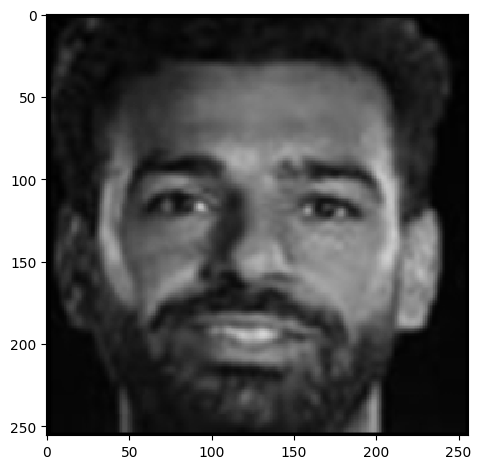

72
0
72
1
72
2
72
3
72
4
72
5
72
6
72
7
72
8
72
9
72
10
72
11
72
12
72
13
72
14
72
15
72
16
72
17
72
18
72
19
72
20
72
21
72
22
72
23
72
24
72
25
72
26
72
27
72
28
72
29
72
30
72
31
72
32
72
33
72
34
72
35
72
36
72
37
72
38
72
39
72
40
72
41
72
42
72
43
72
44
72
45
72
46
72
47
72
48
72
49
72
50
72
51
72
52
72
53
72
54
72
55
72
56
72
57
72
58
72
59
72
60
72
61
72
62
72
63
72
64
72
65
72
66
72
67
72
68
72
69
72
70
72
71
['benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'benzema', 'cr7', 'cr7', 'cr7', 'cr7', 'cr7', 'cr7', 'cr7', 'cr7', 'cr7', 'cr7', 'cr7', 'cr7', 'cr7', 'cr7', 'cr7', 'cr7', 'cr7', 'mo salah', 'mo salah', 'mo salah', 'mo salah', 'mo

In [44]:
test('salaah_2.jpg')

(159, 144)


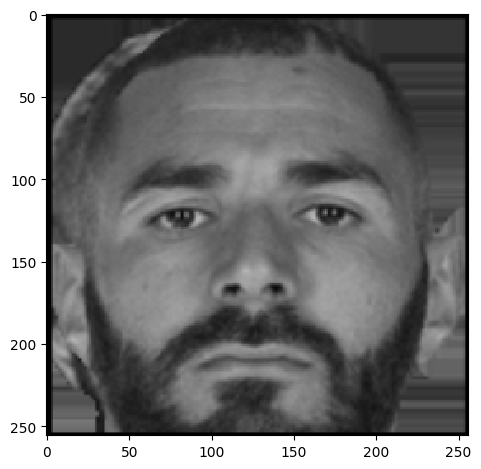

benzema
recognized, horaaaaaay!


In [12]:
test('benzema2.png')

(601, 586)


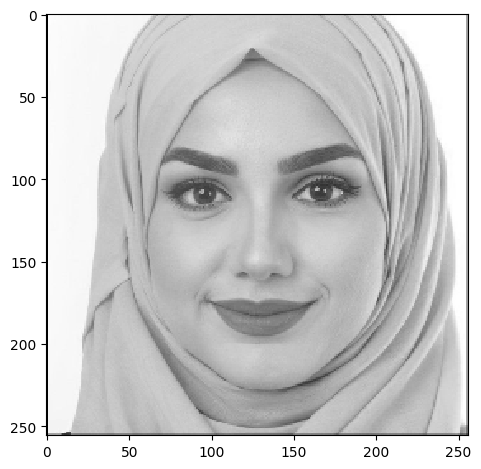

Ooops!not recognized :(


In [13]:
test('no7.jpg')

(154, 139)


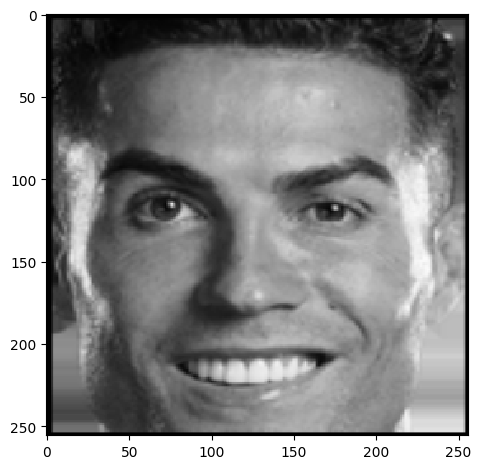

cr7
recognized, horaaaaaay!


In [14]:
test('cr7.png')